**Dataset:**
personality type data (Lab 2 - Personality Profile Type.csv)

**Objective:**
classify Personality type as one of the following **using RNNs**. <br>
['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

**Evaluation metric:**
Precision

### Import used libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import contractions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load Dataset

In [6]:
df = pd.read_csv("Lab 2 - Personality Profile Type.csv")
df.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.|||May the PerC Experience immerse you.|||The last ...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin* That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes. Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your o..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub, Long time no see. Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences, like everything in humanity.|||Draco Malfoy also. I'd say he's either 358 or 368.|||I'm either 358..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to. Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. Just go on permanent vacation.|||Two months? I wouldn't be crazy about the idea. If you are really hi...
5,INTJ,"'18/37 @.@|||Science is not perfect. No scientist claims that it is, or that scientific information will not be revised as we discover new things. Rational thinking has been very useful to our society....|||INFP- Edgar Allen Poe was an INFP and he's in your siggy.|||People see the obvious Fi and are quick to put her as INFP. I agree that she has no Ne. I see her as an ISFP. Compare her to Haku (definite INFP). She is flat through most of Naruto.. but I don't...|||Lets get this party star..."
6,INFJ,"'No, I can't draw on my own nails (haha). Those were done by professionals on my nails. And yes, those are all gel. You mean those you posted were done by yourself on your own nails? Awesome!|||Probably the Electronic Screen Syndrome. With the advent of technology and social media, we all suffer from overstimulation on a daily basis. I'm guilty as well. In the past, I can be happy just...|||I love nail arts too! These are some of mine: 718282 718290 718298 718306 718314|||This is the first..."
7,INTJ,"'I tend to build up a collection of things on my desktop that i use frequently and then move them into a folder called 'Everything' from there it get sorted into type and sub type|||i ike to collect odd objects, even at work...a lot of people would call it junk but i like to collect it. Old unused software? ill take that off your hands :) i have a bunch of old adobe...|||i think its quite normal, i tend to only see my friends in real life every c

### Data splitting

In [7]:
x = df.drop(["type"],axis=1)

In [8]:
y = df['type']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=42, shuffle=True)

In [10]:
x_train, x_val , y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=24, shuffle=True)

### EDA on training data

- check NaNs

In [11]:
x_train.isnull().sum()

posts    0
dtype: int64

- check duplicates

In [12]:
row_duplicated = x_train[x_train.duplicated()]
print(len(row_duplicated))

0


- show a representative sample of data texts to find out required preprocessing steps

In [13]:
x_train.tail()

,posts
5899,"'Sometimes, I think I love Spring, and then Fall comes to remind me why I love it instead.|||di.fm is my jam|||I feel like Business/Management/Marketing degrees are quite open to opportunity for the job seeker to embed him/her self into something they have a passion for. Most job fields require some form of...|||I went to school for Aerospace Engineering and to stick with my HS girlfriend. That led to imminent singularity, and my major turned into Electrical Engineering, which then turned in..."
7995,"'Having some physical action in my life helps to revitalize me and reconnect me with the tangible world when I have absorbed myself for far too long in my thoughts. I am with the other two guys on...|||I don't relate much to this other than that which is highlighted in bold, but here's what I got: __________________________________________________________________________________ Martial State ...|||While I am not sure of being an ISTP myself, I deal with this frequently. I remember when I ..."
3530,"'NomadLeviathan Yeah, it can take this form as well. The hip-ratio is extremely important in regards to healthy childbirth, dating to our evolutionary past. As death during labor was common, mates...|||We love to eat. No doubt about that. I prefer the muscular, hydrated look compared to the ripped, thirsty look any day. Males look for someone healthy, who would be able to safely ensure the arrival...|||Peter You would be wise to take a stab at this from another perspective. Say, if INFJs a..."
4535,"'It sounds catchy although a bit condescending with genius. Maybe c-tard? C for capable.|||Am I allowed to call myself a rucking fetard? On another note..I never considered mentally handicapped people retards. I think it sounds mean to call them retards, but I'm on the fence about...|||hmm so I just wasted time writing my post, since I had an entirely different definition in mind. I thought the word selfish simply meant focusing on self, did not know it means lack of consideration...|||Beca..."
4941,"'I think saying, I like hanging out with you...we have a lot of fun or you make me laugh or you make me think or something of that nature would work better. Shows interest, doesn't assume that you...|||he sounds a little aspie to me...monologue-ing, poor boundary recognition, lack of social cues... Just a thought since I have a teenage aspie at home, it seems familiar.|||Are you referring to the Contest? https://www.youtube.com/watch?v=MhDa9RW0UQE|||Well, I hear you. I think it's mainly (..."


- check dataset balancing

In [14]:
y_train.value_counts()

type
INFP    1324
INFJ    1071
INTP     896
INTJ     794
ENFP     508
ENTP     494
ISTP     245
ISFP     198
ENTJ     174
ISTJ     151
ENFJ     135
ISFJ     114
ESTP      64
ESTJ      34
ESFP      34
ESFJ      31
Name: count, dtype: int64

- Cleaning and Preprocessing are:
    - 1) Remove any numbers
    - 2) Remove URLs, mentions, and hashtags
    - 3) Remove contractions
    - 4) Remove punctuation marks
    - 5) Remove non-ASCII characters and special symbols
    - 6) Lowercase
    - 7) Stop Words
    - 8) Stemmer
    - 9) Tokenizer

### Cleaning and Preprocessing(data train)

In [15]:
# Remove any numbers
x_train['posts'] = x_train['posts'].apply(lambda x:re.sub('\d+',"",x))

In [16]:
# Remove URLs, mentions, and hashtags
x_train['posts'] = x_train['posts'].apply(lambda x: re.sub('http\S+|www\S+|@[^\s]+|#\S+',"",x))

In [17]:
def preprocess_text(text):
    # Remove contractions
    expanded_text = contractions.fix(text)
    # Remove punctuation marks
    cleaned_text = expanded_text.translate(str.maketrans('', '', string.punctuation))
    return cleaned_text

In [18]:
x_train['posts'] = x_train['posts'].apply(preprocess_text)

In [19]:
# Remove non-ASCII characters and special symbols
x_train['posts'] = x_train['posts'].apply(lambda x: re.sub(r'[^\x00-\x7F]+',"",x))

In [20]:
#Lowercase
x_train['posts'] = x_train['posts'].apply(lambda x: x.lower())

In [21]:
stop_words = stopwords.words('english')

In [22]:
stemmer = PorterStemmer()

In [23]:
# function to stem each word in a posts
def stem_words(text):
    # split post to words
    words = text.split()
    # Stem each word using the  Stemmer
    stemmed_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
    # Join the stemmed words back into a single string
    stemmed_post = ' '.join(stemmed_words)
    return stemmed_post

In [24]:
x_train['posts'] = x_train['posts'].apply(stem_words)

In [25]:
x_train.head(50)

,posts
6131,thought meant liter rewrit physic base scientif endeavor lame cannot help goodbyei hate everyth intpgoddamn hate oblivi se wrong forum thank perc let delet postsoh waitwtfi probabl nine herei add asperg gadsad consequ also avpd could help whether istj still question ask well realli cope enjoy sleep anyth way feel like shit take around hour feel like shit infp see everyon monster kidnap tortur realli cannot help ok guess video link workit depress imagin day someth like would dead actual want ...
8109,ue sale x well worn sens self control easi abus disciplin requir ideal slow learner regret sale due current owner move outer space allwhen young would imagin way charact role fairli often see get sure find part scan tendenc acut view thingsevolv without constraintpunctu ongo battl tri rationalis thing work often refus put key belongjust retreat back give opportun kick around score extra point name mario super way canonc around seven brother five dismantl local bank branch whilst mom thing qu...
7441,rememb thing make sens like datainfo make pattern fit someth bigger logic pathconclus etc thing person find uninterest awfulh narcissistsociopath mbti appli peopl person disordersi want see realli matter shoe collectionbrilli respons rolleyesskim first page might repetit love netflix like watch tv show without commerci break fit watch schedul instead thewhi post question advic forum type person problem look address person problem relat peopl opinion trump thebett time almost step shit right ...
2538,relat invers spend absurd amount time tri beat imposs video game put someth like sudoku front end crush page eatingi idea name thank ton link got one thing read aboutfin someon understandssnor horribl tri use cellphon alarm mine set vibrat feel alarm hear might worth shot could wear earplug copypasta delici one timesnow feel bad crack knuckl back time actual kill joint though knowfor sound someon chew especi look shoulder tri tell someth make feel like need go destroy planet idea butpretti m...
8595,never know right wrong discuss frazzl oppon argument like matinalsmoothi act like right wrong belief father andit definit harder manipul thinker feeler want manipul thinker prone logic want understand want thing getmi best friend infp exactli damn good imit boss funni run realli fast make look like fall realli hard iti think mani peopl clue like entp intj read descript internet say exactli peopl read thread andyeah realli good tip thank go next week ask question nice talk much contact peopl ...
3270,one morn jeremiah lord say curs put trust mere human reli human strength turn heart away thethos great vers good point good comfort vers seem like everybodi enemi need realiz one physic peopl real enemi likeyour face ugli walk street guy even know read newspap heard footstep close paper put besid lower hisi think alway conting planner though never realli plan mayb subconsci defens fail plan exist cannot fail yupsit work cramp neck contempl take tie shed jacket end lazywak lament realli eat b...
6463,thank repli compens someth els definit sound interest know feel complet like late date someon veryhi got strang one mayb find late feel pretti usual second day background nurs work prettyfor whatev reason post suggest natur kind reson think direct need take nowi think convers could similar pray though never realli pray whatev reason like idea pray think percept personani recommend spiritu read make lot sens belief god fairli similar seem whatev reason look inward feel quit right right feel l...
3629,ok happi give time organis trip proudi would need ride montreal ever meet still room essay decemb busi month peopl chrristma parti come work weekend outwelcom happycongratul happywelcom happycongratul happyi rememb use stuff like brother weird big hug relat tri say hope help make feel better sister use tell go interview isi think someth els happen wonder even though take time tell like said never spoken like want mess hislaurel k hamilton anita blak

**You  are doing Great so far!**

###Cleaning and Preprocessing(data validation)

In [26]:
# Remove any numbers
x_val['posts'] = x_val['posts'].apply(lambda x:re.sub('\d+',"",x))

In [27]:
# Remove URLs, mentions, and hashtags
x_val['posts'] = x_val['posts'].apply(lambda x: re.sub('http\S+|www\S+|@[^\s]+|#\S+',"",x))

In [28]:
x_val['posts'] = x_val['posts'].apply(preprocess_text)

In [29]:
# Remove non-ASCII characters and special symbols
x_val['posts'] = x_val['posts'].apply(lambda x: re.sub(r'[^\x00-\x7F]+',"",x))

In [30]:
#Lowercase
x_val['posts'] = x_val['posts'].apply(lambda x: x.lower())

In [31]:
#stemmer
x_val['posts'] = x_val['posts'].apply(stem_words)

In [32]:
x_val.head(50)

,posts
7168,wolf well lord elgin partial intact greek sculptur british museumbritish museum greek sculptur robbi dpchalleng starri nightvinc van goghth starri night wikipedia freerazef hope feel better soon mate wear heart sleev even want highli proud stubborn anyth protect peopl loveshug hug anyon worri mate subscrib theori organ chao come person spaceshug courtesi upper bodi crippl take advantag offer stillalasth imag abl seen mufasa hug rafikihappi spring break hug go old school lion kingthread reviv...
5458,doll love movi list make think trityp one fave heal abil often attribut might somehow benefit thereabuseabandon caus ness basic freez us emot thu black white simplic overwhelm emot control tendenc symptom deeperswordsman mana know million year sinc thread got start your still interest could tell think trityp love read commentshi guy fionn whitehead star nolan dunkirk lead he newcom well media train reaction seem pretti genuin think got type watchingenneagram stack might play bigger role type...
4758,wow realli piss peopl post piec geniu creat simpl would go elementari school onesi around sothi simpl would go elementari school onesi around right get recess would go place central school like black topdemond sad idiot inferior complex realiz potenti smart einstein ever want truli intellig manyi complet disagre peopl rais extrovert commun famili later teen discov introvert intp believ born withi think entp show crime scene rather plan show face larg one get point across behind everythingsch...
3922,definit fi even littl kid easili sway popular consensuscontrol constantli critic treat unfairli disrespectenfpmi istj like servic touch action love languagesesfp word affirm qualiti timei sure great person littl uptight side live littl funni thread best troll seen whileright excit read intj dri reapons next stop istp estpit amus even get stir peopledear posh eagl pleas make thread sincer super amus avoid workhaha love itti subject itquit analog someon need take cold shower huh would make sen...
5036,apolog brought life anyth like mine thread like probabl appear forum bounc perc everi month cannotlimit experi known two pretti lukewarm irrever humour funni yesbut two known guy friend pretti arrog found theiri know would write one us mean interest definit go page think book could written singl mbti typein life matter much littl money made abl surviv pretti well plan financ alway manag live decent even got theremi mom esfj overal good relationship certainli one think n part person area caus...
5213,obvious mean mental defici prove kid internetspecif ami thought trump ooh know one two kind judgement answer essay one favorit essayist worri futur done plenti find iti mind textbas smiley use sparingli think imag one kind tacki use exclam mark one per sentenc like peopl dopon farrwhat scari question even like think would hurt judg number offtop snarki repli thread one howev also anestp glanc type closeuh video miss someth anyway thank think emot energi power learn use cours definit aw diffi...
1464,time realli wish e less ii prudent choos least damag method situat regardless tell truth keep note tell lyingentp similar intp except better express make less weird peopl understand themit anyth visual lewd could never imagin sex guy formless voic hot beyond whole movi touch definit worthsoci condit pretti much part outer circumst right exactli reject youvr porn conscienc shit man ever seen movi sex scene fuck hotmal femal matter well sometim strong belief outwardli appear like ego tend vigi...
1163,fault popular anyon recent began read want give tomoko big hugoh nice guess could intj insteadstrok one white fluffi cat mash face laugh globe maniac guess xsfj lot lot si feheh oneup everyonei even notic mention annoy shit point someth would rather mention sure deduc anoth tablink worth watch rude donnetout cechic etromantiqu alor faisonsl comm il le font sur ububdcouvert canal je tien vou dire comment se plonger dan ta chatt caverneux nou allon te

###Cleaning and Preprocessing(data test)

In [33]:
# Remove any numbers
x_test['posts'] = x_test['posts'].apply(lambda x:re.sub('\d+',"",x))

In [34]:
# Remove URLs, mentions, and hashtags
x_test['posts'] = x_test['posts'].apply(lambda x: re.sub('http\S+|www\S+|@[^\s]+|#\S+',"",x))

In [35]:
x_test['posts'] = x_test['posts'].apply(preprocess_text)

In [36]:
# Remove non-ASCII characters and special symbols
x_test['posts'] = x_test['posts'].apply(lambda x: re.sub(r'[^\x00-\x7F]+',"",x))

In [37]:
#Lowercase
x_test['posts'] = x_test['posts'].apply(lambda x: x.lower())

In [38]:
#stemmer
x_test['posts'] = x_test['posts'].apply(stem_words)

In [39]:
x_test.head(50)

,posts
2802,lie avoid unreason respons someth complet justifi tri justifi someon els would hung iyour iq sd typic difficult time maintain friend come realiz peopl talk year still want talk got bore theman intj friend mine told realli hate eat repetit intp realli feel bother realli regist eat think aboutsimilar mind advanc testintp sxso lot friend one speak actual feel talk actual think regard toget close someon end want infinit close end merg everi damn timeinterest topic know two enfp strang intp view ...
2166,said zero flexibl littl time date go around sift date find one click go viabl noth maintain relationship ihow come conclus noth offer mere busi beyond realli made stuffokay cool specif look get relationship enter life phase resourc give relationship isi take slow still singl interest make friend friend enough like interest go date intent enter aabsolut find idea repugn actuallypeopl could polit mayb averag conserv bet claim social butterfli normal guy introvert social doofu noti probabl give...
1919,written bia someth sure could even say truth reason put subject god man say noth make main prioriti church written throughout text past nearli year reverber throughout church dialogu incid aboutthat annoy phrase obtus confus newcom blame respons must reveal knowledg speak truth contain biasther priestli desk job closest thing priest get away peopl monk differ tell outno realli cannot go intp assum intellig level would end failur afraid ask big question muse intp tri toheresi like core reason...
360,hauhuhauh might right muhicz wonder step come exactli age like said tought believ scientif realli matter point isthank misterjordan word helpful help think conflict beetwen fi ti could inner develop improv must say thei read fe fi function fi also know well mbti type stdi last year fi prefer mean enfp still weird shouldi possibl chang archetyp enfp proud knew year ago sometim ago start get act like entp last year live allar sure entp mobi sound like entj great marshal achiev seek power domin...
1115,parent kind go colleg good job peopl want stabl career hand want travel perhap teach english foreign land especi ini friend go crisi graduat high school absolut know idea life anyth realli passionatei recent met waitress one restaur town serv live know paper waiter bartend make less minimum wage receiv tip ixmy one rel close femal friend istp three main guy friend intj intp es ft ji done thisi asham sat score cr w ration deal job requir major use sens function met entp hairdress intj electri...
623,iron consid signatur cat better peopl cat known kill play prey fun think wrong wereooh virgo rise infj virgo also one fav zodiac sign infj kind honest childhood friend even year talk would happi check andi consum machiavellian dark period life sometim get fed fake peopl lie around other perceiv truth realiti instead focuspeopl tend gener like tri care polit offend order turn know come intimid think need toi get overwhelmingli sarcast iron person interest flirt come natur hate person interest...
1741,well said codgery like proudnev mind apolog intrusiontru hey cetanu ya doin hey chancyros ya add list punch bag thing realli worki got mine world still retardedamong thingsgood luckub good morn peopleanyway noth go bed deal whatev bullshit subconsci store least would chang sceneryi sorri one thoseub daysa condit mani countri day religion use excus abus power would make exampl outta hellova thing think bed lofuggitsigh say allbeth realiz one socal islam countri right come alcohol famili inter...
5818,curiou realis bit stupid question bound generalis would anyth way nf look dress etc distinguish othersi relat much ridiculousnoth goe unnoticedi deal loneli rationalis shoo away work less half time focus main current goal success use loneli excus wellaerospac engin check civil engin electron engin econom w busi manag psycholog comput scienc english music physic w astronomi mbayeah somewhat agre join photographi societi univers pretti much event consis

###Tokenizer

In [40]:
#convert the text into numerical representations
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['posts'])
sequences = tokenizer.texts_to_sequences(x_train['posts'])

In [41]:
vocab_size = len(tokenizer.word_index) + 1

In [42]:
vocab_size

204752

In [43]:
max_sequence_len = max(len(seq) for seq in sequences)
print("Maximum sequence length :", max_sequence_len)

Maximum sequence length : 910


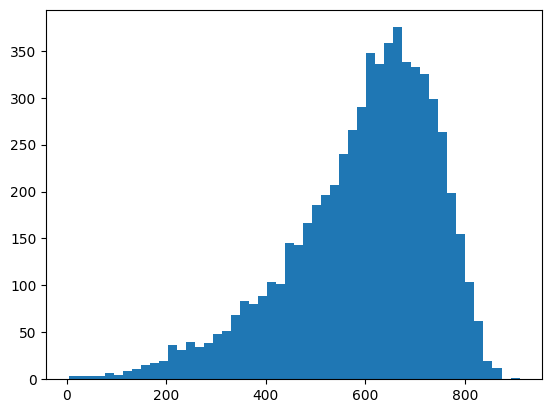

In [44]:
#another way to calculate Maximum sequence length
lengths = [len(s)for s in sequences]
plt.hist(lengths, bins=50)
plt.show()

In [45]:
x_train_padded = pad_sequences(sequences, maxlen=max_sequence_len, padding='post', truncating='post')

In [46]:
# Convert text data to sequences of tokens for validation set
sequences_val = tokenizer.texts_to_sequences(x_val['posts'])
x_val_padded = pad_sequences(sequences_val, maxlen=max_sequence_len, padding='post', truncating='post')

In [47]:
# Convert text data to sequences of tokens for testing set
sequences_test = tokenizer.texts_to_sequences(x_test['posts'])
x_test_padded = pad_sequences(sequences_test, maxlen=max_sequence_len, padding='post', truncating='post')

In [48]:
# Check the shapes of padded sequences for each set
print("Shape of x_train_padded:", x_train_padded.shape)
print("Shape of x_val_padded:", x_val_padded.shape)
print("Shape of x_test_padded:", x_test_padded.shape)

Shape of x_train_padded: (6267, 910)
Shape of x_val_padded: (1106, 910)
Shape of x_test_padded: (1302, 910)


### Modelling

In [49]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Fit label encoder and transform labels in y_train
y_train_encoded = label_encoder.fit_transform(y_train)

In [50]:
y_val_encoded = label_encoder.transform(y_val)

In [51]:
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size,max_sequence_len),
    tf.keras.layers.SimpleRNN(100,return_sequences=True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(16,activation='softmax')
])

In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_padded, y_train_encoded, epochs=5,
                    validation_data=(x_val_padded, y_val_encoded))


Epoch 1/5
196/196 [==============================] - 348s 2s/step - loss: 2.2916 - accuracy: 0.2113 - val_loss: 2.2589 - val_accuracy: 0.2025
Epoch 2/5
196/196 [==============================] - 343s 2s/step - loss: 2.2906 - accuracy: 0.2113 - val_loss: 2.2615 - val_accuracy: 0.2025
Epoch 3/5
196/196 [==============================] - 343s 2s/step - loss: 2.2903 - accuracy: 0.2113 - val_loss: 2.2651 - val_accuracy: 0.2025
Epoch 4/5
196/196 [==============================] - 343s 2s/step - loss: 2.2896 - accuracy: 0.2113 - val_loss: 2.2664 - val_accuracy: 0.2025
Epoch 5/5
196/196 [==============================] - 343s 2s/step - loss: 2.2905 - accuracy: 0.2113 - val_loss: 2.2579 - val_accuracy: 0.2025


#### Evaluation

**Evaluation metric:**
Precision

In [ ]:
# Predict the labels for the test data
y_pred = model.predict(x_test_padded)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')

print('Precision: {:.4f}'.format(precision))

41/41 [==============================] - 6s 130ms/step
Precision: 0.0476


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Enhancement

Using Bidirectional with GRU and reduce max_sequence_len = 800 instade of 910 words

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size,800),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=200)),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 800)         163801600 
                                                                 
 bidirectional_1 (Bidirecti  (None, 400)               1202400   
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 100)               40100     
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 16)                816       
                                                                 
Total params: 165049966 (629.62 MB)
Trainable params: 165049966 (629.62 MB)
Non-trainable params: 0 (0.00 Byte)
________

In [ ]:
model2.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

In [ ]:
history = model2.fit(x_train_padded, y_train_encoded, epochs=50 ,validation_data=(x_val_padded, y_val_encoded))

Epoch 1/50
196/196 [==============================] - 63s 292ms/step - loss: 2.3393 - accuracy: 0.1913 - val_loss: 2.2639 - val_accuracy: 0.2025
Epoch 2/50
196/196 [==============================] - 47s 242ms/step - loss: 2.2535 - accuracy: 0.2180 - val_loss: 2.2990 - val_accuracy: 0.1646
Epoch 3/50
196/196 [==============================] - 45s 230ms/step - loss: 2.1502 - accuracy: 0.2323 - val_loss: 2.3335 - val_accuracy: 0.1618
Epoch 4/50
196/196 [==============================] - 41s 211ms/step - loss: 2.0504 - accuracy: 0.2457 - val_loss: 2.4691 - val_accuracy: 0.1609
Epoch 5/50
196/196 [==============================] - 36s 186ms/step - loss: 2.0083 - accuracy: 0.2679 - val_loss: 2.5095 - val_accuracy: 0.1637
Epoch 6/50
196/196 [==============================] - 36s 181ms/step - loss: 2.1040 - accuracy: 0.2441 - val_loss: 2.3793 - val_accuracy: 0.1727
Epoch 7/50
196/196 [==============================] - 35s 177ms/step - loss: 2.2060 - accuracy: 0.2165 - val_loss: 2.3272 - val_ac

Evaluation

In [ ]:
y_pred = model2.predict(x_test_padded)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')

print('Precision: {:.4f}'.format(precision))

41/41 [==============================] - 2s 45ms/step
Precision: 0.1297


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using Bidirectional with LSTM

In [52]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size,max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100)),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='softmax')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 910)         186324320 
                                                                 
 bidirectional (Bidirection  (None, 200)               808800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
Total params: 187159086 (713.96 MB)
Trainable params: 187159086 (713.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [53]:
model1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

In [58]:
history = model1.fit(x_train_padded, y_train_encoded, epochs=50 ,validation_data=(x_val_padded, y_val_encoded))

Epoch 1/50
196/196 [==============================] - 35s 180ms/step - loss: 1.7609 - accuracy: 0.4150 - val_loss: 2.6092 - val_accuracy: 0.1781
Epoch 2/50
196/196 [==============================] - 34s 173ms/step - loss: 1.7027 - accuracy: 0.4307 - val_loss: 2.7951 - val_accuracy: 0.1591
Epoch 3/50
196/196 [==============================] - 32s 165ms/step - loss: 1.6520 - accuracy: 0.4599 - val_loss: 2.7652 - val_accuracy: 0.1772
Epoch 4/50
196/196 [==============================] - 33s 167ms/step - loss: 1.6136 - accuracy: 0.4736 - val_loss: 2.8715 - val_accuracy: 0.1600
Epoch 5/50
196/196 [==============================] - 31s 157ms/step - loss: 1.5662 - accuracy: 0.4867 - val_loss: 2.8533 - val_accuracy: 0.1682
Epoch 6/50
196/196 [==============================] - 31s 160ms/step - loss: 1.5358 - accuracy: 0.4990 - val_loss: 3.0908 - val_accuracy: 0.1790
Epoch 7/50
196/196 [==============================] - 31s 159ms/step - loss: 1.5021 - accuracy: 0.5100 - val_loss: 2.9434 - val_ac

Evaluation

In [59]:
# Predict the labels for the test data
y_pred = model1.predict(x_test_padded)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')

print('Precision: {:.4f}'.format(precision))

41/41 [==============================] - 2s 39ms/step
Precision: 0.1475


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion and final results


 The best model is Using Bidirectional with LSTM, Percision_Score = 14.75%

#### Done!